# Stability Analysis of Time-Delayed Networks
David Reber and Hayden Ringer

# I. Introduction

Many systems in the sciences can be expressed as *dynamical networks*, that is, where a set of individuals (nodes) transfer some quantity between them (edges) as a function of time. For example, consider a network of computers, all exchanging information with each other (such as the Internet). In the study of dynamical networks, it is important to consider the question of *stability*: does the network have certain so-called *stable* states that persist in time?

Consider again a network of computers. Perhaps there is a stable, predictable pattern of traffic in the network. What would result from causing a time delay in one of the connections in the network? Would the current flow of traffic persist? Would a new, different stable state emerge? Or would the network itself be thrown into instability?

More generally, how does delaying the interactions between a subset of individuals in a dynamical network change the eventual equilibrium of the system?

### Formal Mathematical Statement

If we restrict our study to discrete-time networks, we can describe them in this form:

$$x_{t+1} = A x_t$$

Where $x_t$ is the *state vector* at time $t$, and $A$ is the matrix of coefficients of the system.

The stability of this system is determined by the eigenvalues of the coefficient matrix. If all eigenvalues have norm less than 1, then the system has a stable equilibrium. In discrete time, a time delay corresponds to splitting an edge and adding a “dummy” node. One of the resulting edges is given a weight of 1, and the other is given the original weight. We then say that the interaction is delayed by 1 time step. A time delay in this system can be represented by the following map:

$$d_{i,j}: M_{n}(\mathbb{R}) \rightarrow M_{n+1}(\mathbb{R})$$

$$\begin{bmatrix}
a_{11} & ... & a_{1j} & ... & a_{1n}\\ 
\vdots & \ddots & \vdots &  & \vdots\\ 
a_{i1} & ... & a_{ij} & ... & a_{in}\\ 
\vdots &  & \vdots & \ddots & \vdots\\ 
a_{n1} & ... & a_{nj} & ... & a_{nn}
\end{bmatrix} \rightarrow \begin{bmatrix}
a_{11} & ... & a_{1j} & ... & a_{1n} & 0\\ 
\vdots & \ddots & \vdots &  &  & \vdots\\ 
a_{i1} & ... & 0 & ... & a_{in} & 1\\ 
\vdots &  & \vdots & \ddots &  & \vdots\\ 
a_{n1} & ... & a_{nj} & ... & a_{nn} & 0\\ 
0 & ... & a_{ij} & ... & 0 & 0
\end{bmatrix}$$

To determine the stability of a once-time-delayed system would (in a brute force approach) require calculating the eigenvalues of the (n+1)-by-(n+1) coefficient matrix. To determine the weakest link, we would need to repeat the $O(n^3)$ eigenvalue problem for each of the $n^2$ edges in the original network. To determine stability under delays past 1st order, we would need another $n^2$ eigenvalue calculations for each level of delay. Thus, the brute-force approach would require $O(n^{2D+3})$ operations, where $D$ is the depth of the delay calculation. Obviously, for large systems and significant depth requirements, this becomes intractable.

Therefore, we wish to identify a non-brute-force approach that could heuristically identify destabilizing edges, which would represent a significant practical tool for network analysis and could also give insight into the general properties that determine stability under time delays. 
Ideally, this will result in numerically-informed guidelines for which edge destabilizes the system most when time-delayed. These guidelines would need to be simple enough to be understandable and hopefully analytically provable.

However, it would still be remarkable to train a machine learning algorithm to identify destabilizing links in a network, even if the discriminating factors are obscured, such as in a random forest. Such a success would indicate the existence of conditions for a set of edges to be destabilizing under time delays.

The formal questions we wish to answer can be summarized as:

- Given information about a network, can we predict which edges increase the spectral radius (i.e. decrease stability) when time-delayed?
- Can we predict these edges using rules simple enough to be proven analytically?

# II. Data Generation

As our problem is mathematical, our dataset is artificially generated, rather than collected (from observations). Our core motivation for this research is to inform a future analytic result in stability theory for time-delayed networks. That objective leads us to several preferences for our dataset:

1. It is sufficient to study low-dimensional networks. While larger networks certainly exhibit more complicated interactions, there is no fundamental difference (in terms of stability) between a network with one thousand nodes and a network with just three. By examining only small networks, our problem becomes more computationally tractable.

2. It suffices to study only strongly-connected networks (in the graph theoretic sense). Any network that is not strongly connected can be broken into strongly-connected sub-networks that can be studied individually. For example, this simplifying assumption allows us to split our study of three-node networks into the 30 non-isomorphic strongly connected digraphs.

3. We restrict the edge weights in our networks to the range [-2,2]. The resulting networks have a wide distribution of spectra. This gives us a good balance of networks with stable and unstable initial configurations.

With the three ideas above, we chose to generate 1000 samples from each graph isomorphic equivalence class. In order to train a learning algorithm, we also needed to provide labels for the dataset. For each network, we performed a time-delay transformation on each edge, and then calculated the resulting change in spectral radius. Thus each edge in a network in the dataset is linked to the actual result of a time delay.

In summary:

1. For a given dimension $n$ (starting with $n=3$), load all nonisomorphic strongly connected digraphs as an $n$-by-$n$ matrix of 1's and 0's
2. Add all non-isomorphic combinations of self-loops
3. For each of the networks, generate 1000 samples by populating the non-zero entries with values drawn uniformly from $[-2,2]$. Store as "networks"
4. For each of the generated samples, calculate the spectral radii corresponding to each possible time delay. Store the array as "effects"
5. Store the data as data[n].npz, with a "networks" and "effects" array


For illustrative purposes, consider how the temporal and spacial complexity increases as a function of $n$:

$n=2$: 0.145 seconds, 3 equivalence classes

$n=3$: 0.172 seconds, 30 equivalence classes

$n=4$: 7.717 seconds, 1168 equivalence classes

$n=5$: 9873.413 seconds, 155510 equivalence classes

(Note: The code used to generate the dataset can be found in "helper_functions.py")

# III. Data Visualization and Feature Selection

Feature selection represents a uniquely difficult challenge in developing this model. On one hand, our dataset is "complete": the behavior of each generated network is fully determined by the information contained in the network matrix. On the other hand, the network matrix itself doesn't immediately reveal which mathematical properties are relevant in determining stability after time-delays.

Thus a core problem for our model is to define and engineer measurements based on the network matrix that correlate with the change in spectral radius after a time-delay (our measure of stability). Several measurements have shown themselves to be useful:

1. Cycle products
2. Graph isomorphism
3. Spectral properties
4. Determinant properties

In [1]:
from helper_functions import *
%matplotlib inline

# The dimension of individual networks
n = 3

# Number of samples per class
num_samples = 1000

In [2]:
#Load Data
data = np.load("raw_data/data" + str(n) + ".npz")
networks, effects = data['networks'], data['effects']

In [3]:
#Generate all_cycles
all_cycles, all_cycles_edges, all_cycles_effects = all_cycles_vals_effects(networks, effects)

## Cycle products

A cycle is a closed path in a network, such that no edge or node is visted more than once in the path. In some sense, a cycle can be considered as a "feedback loop" within the system. The cycle product is the product of edge weights along a given cycle, thus revealing the magnitude of feedback within the cycle.

We explore the relationship between cycle products and the change in spectral radii. Note that since multiple edges lie along a cycle, there are multiple spectral effects corresponding to a single cycle. The resulting distribution appears to have some structure, confirming our hypothesis that cycle products are indeed related to network resilience.

In [4]:
ravel_cycles, ravel_cycles_edges, ravel_cycles_effects = ravel_on_cycle(all_cycles, all_cycles_edges, all_cycles_effects)

In [5]:
# Plot cycle products (x-axis) against the change in spectral radius on that cycle (y-axis).
cycle_products = [np.product(cycle) for cycle in np.array(ravel_cycles_edges)]
spectral_changes_avg = [np.mean(cycle) for cycle in np.array(ravel_cycles_effects)]
spectral_changes_max = [np.max(cycle) for cycle in np.array(ravel_cycles_effects)]
spectral_changes_min = [np.min(cycle) for cycle in np.array(ravel_cycles_effects)]

cycle_products_avg_change = pd.DataFrame(np.vstack((cycle_products, spectral_changes_avg)).T)
cycle_products_max_change = pd.DataFrame(np.vstack((cycle_products, spectral_changes_max)).T)
cycle_products_min_change = pd.DataFrame(np.vstack((cycle_products, spectral_changes_min)).T)

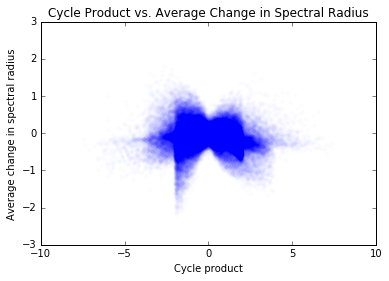

In [6]:
cycle_products_avg_change.plot(kind='scatter', x=0, y=1, linewidth=0, alpha=.01)
plt.title("Cycle Product vs. Average Change in Spectral Radius")
plt.ylabel("Average change in spectral radius")
plt.xlabel("Cycle product")
plt.show()

This distribution clearly has structure. It confirms our intuition that as the cycle product goes to zero, the spectral radius changes less to delays - this indicates a strong relationship between cycles and eigenvalues. However, we do not understand why the distribution has multiple peaks and gaps, especially in the third quadrant.

## Graph Isomorphism

As we began implementing machine learning methods, we found that our initial features were insufficient. In order to better identify which features to use, we attempted to better visualize our data. We found that, when we split our data into categories of graph isomorphism, that strong patterns appeared when plotting cycle products against change in spectral radius. A sample of these plots are below:

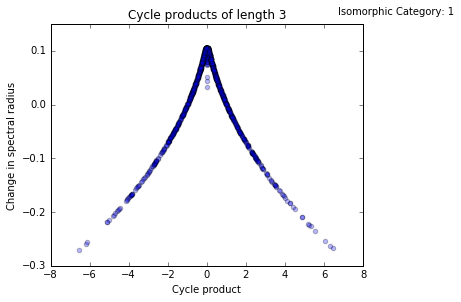

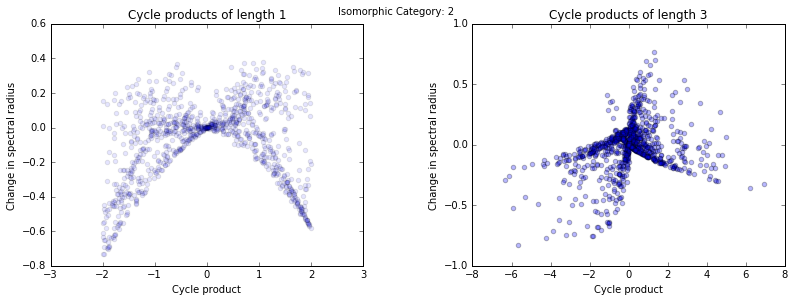

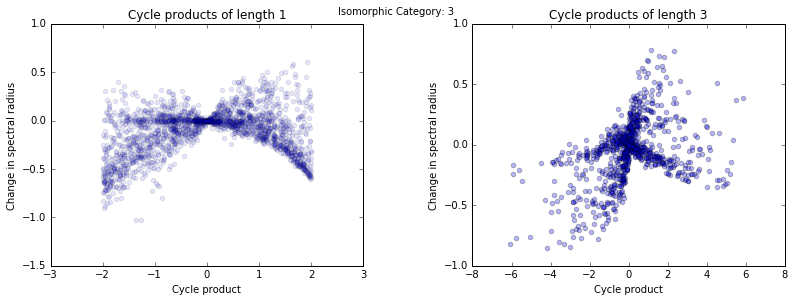

In [7]:
rcParams['figure.figsize'] = (12,4)
for m in xrange(3):
    sums, delta_rho = lenk_cycle_product_sums(networks[m*num_samples:(m+1)*num_samples],effects[m*num_samples:(m+1)*num_samples])
    for i, k in enumerate(sums.keys()):
        plt.subplot(1,2,i+1)
        plt.scatter(sums[k],delta_rho[k],alpha=.1)
        plt.title("Cycle products of length {}".format(k))
        plt.ylabel("Change in spectral radius")
        plt.xlabel("Cycle product")
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    plt.suptitle("Isomorphic Category: " + str(m+1))
    plt.show()
rcParams['figure.figsize'] = (6,4)

These plots reveal that the relationship between cycle products and change in spectral radius is highly dependent on which isomorphic equivalence class the network belongs to. In essense, these plots are revealing the overlaid structures from the original cycle product plot.

## Spectral properties

As our measure of stability is spectral, it stands to reason that the spectral properties of the network itself are important to consider. For a given network of dimension $n$, there are $n$ eigenvalues, counting multiplicity. Below, we plot the magnitude of the largest eigenvalue against the change in spectral radius.

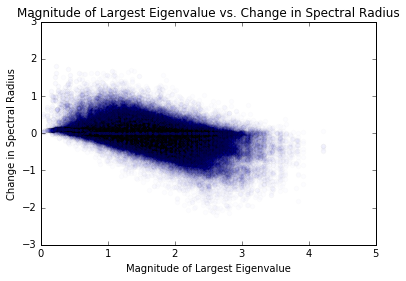

In [8]:
dim = np.shape(networks[0])[0]
X = []
y = []
for k in xrange(len(networks)):
    network = networks[k]
    effect = effects[k]
    iso_category = k/num_samples
    evals = list(np.sort(np.abs(np.linalg.eigvals(network))))[::-1]
    for i in xrange(dim):
        for j in xrange(dim):
            edge = (i,j)
            if network[edge]:
                X.append(evals[0])
                y.append(effect[edge])
plt.scatter(X,y,alpha=.01)
plt.title("Magnitude of Largest Eigenvalue vs. Change in Spectral Radius")
plt.xlabel("Magnitude of Largest Eigenvalue")
plt.ylabel("Change in Spectral Radius")
plt.xlim(0,5)
plt.show()

The resulting region has fairly clear boundaries, and gives insight into which networks tend towards or away from stability after time delays. If $|\lambda_1| < 1.5$, the change in spectral radius is more likely to be positive, while the opposite is true for $|\lambda_1| > 1.5$.

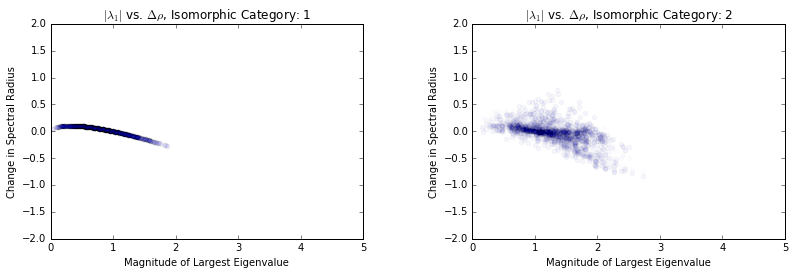

In [9]:
rcParams['figure.figsize'] = (12,8)
for m in xrange(2):
    X = []
    y = []
    for k in xrange(m*1000,(m+1)*1000):
        network = networks[k]
        effect = effects[k]
        evals = list(np.sort(np.abs(np.linalg.eigvals(network))))[::-1]
        for i in xrange(n):
            for j in xrange(n):
                edge = (i,j)
                if network[edge]:
                    X.append(evals[0])
                    y.append(effect[edge])
    plt.subplot(2,2,m+1)
    plt.scatter(X,y,alpha=.01)
    plt.title(r"$|\lambda_1|$ vs. $\Delta \rho$, Isomorphic Category: " + str(m+1))
    plt.xlabel("Magnitude of Largest Eigenvalue")
    plt.ylabel("Change in Spectral Radius")
    plt.xlim(0,5)
    plt.ylim(-2,2)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()
rcParams['figure.figsize'] = (6,4)

As with the cycle products, we also display the resulting plots when restricted to just one of the isomorphic equivalence classes.

## Determinant Products

We previously found that cycle products seem to be very important. From the permutation definition of the determinant, one can prove that the determinant is a sum (and difference) of cycle-product combinations of length $n$. For example, the determinant of a 2x2 matrix is $a_{11}a_{22} - a_{12}a_{21}$, the difference of a two-cycle and two one-cycles (both of which have combined length 2). 

Furthermore, each edge can occur once in each product, or not at all; thus the determinant is linear with respect to a given edge weight. Given an edge, the code below finds and returns the slope and intercept of this line, with other useful comparisons.

Below we plot the determinant slope by the chance in spectral radius.

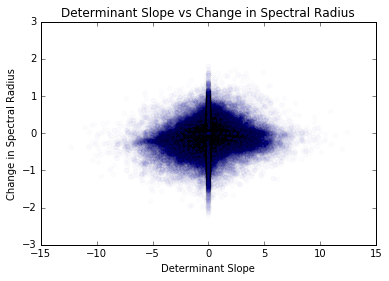

In [10]:
X = []
y = []
for k, network in enumerate(networks):
    effect = effects[k]
    for i in xrange(n):
        for j in xrange(n):
            edge = (i,j)
            if network[edge]:
                X.append(determinant_features(network,(i,j))[0])
                y.append(effect[edge])
                
plt.scatter(X,y,alpha=.01)
plt.xlabel("Determinant Slope")
plt.ylabel("Change in Spectral Radius")
plt.title("Determinant Slope vs Change in Spectral Radius")
plt.show()

This plot reveals that the determinant slope alone doesn't clearly disinguish between increases or decreases in spectral radius.

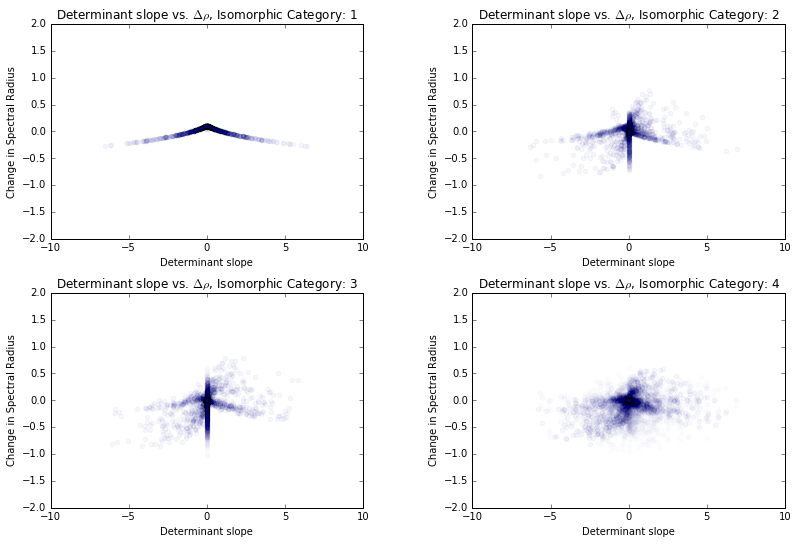

In [11]:
rcParams['figure.figsize'] = (12,8)
for m in xrange(4):
    X = []
    y = []
    for k in xrange(m*1000,(m+1)*1000):
        network = networks[k]
        effect = effects[k]
        for i in xrange(n):
            for j in xrange(n):
                edge = (i,j)
                if network[edge]:
                    X.append(determinant_features(network,(i,j))[0])
                    y.append(effect[edge])
    plt.subplot(2,2,m+1)
    plt.scatter(X,y,alpha=.01)
    plt.title(r"Determinant slope vs. $\Delta \rho$, Isomorphic Category: " + str(m+1))
    plt.xlabel("Determinant slope")
    plt.ylabel("Change in Spectral Radius")
    plt.xlim(-10,10)
    plt.ylim(-2,2)                
                
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()
rcParams['figure.figsize'] = (6,4)

However, when split on isomorphic category, the plots reveal clear structure, similar to the cycle product forms.

# IV Machine Learning

There are two broad approaches to consider for using machine learning on our dataset:

1. Classification of edges based on changes in stability: does a delay on a given edge increase or decrease the stability (spectral radius) of the network?
2. Regression on the actual absolute change in spectral radius for a given edge.

Accomplishing the latter would be ideal, as it would also give us the former. However, it could represent in a simpler, more accurate model if we only use a classification scheme. We will implement and compare both approaches.

Classification Algorithms:
* Logistic Regression
* Decision Tree
* Random Forest Classifier

Regression Algorithms:
* Linear Regression
* Ridge Regression
* Random Forest Regression

Recall from Data Visualization: we found that different isomorphic categories exhibited unique structures in cycle products, spectral properties, and determinant properties. However, in our initial efforts, we found that most of the machine learning techniques naively under-utilized the distinction of isomorphic categories. So, we first split our dataset according to isomorphic category, and then train all of the models on each equivalence class, and record the overall accuracy. In the context of a tree or forest model, this corresponds to enforcing a first-level split on isomorphic category.

When evaluating these algorithms, it is important to measure their accuracy relative to some baseline. For our analysis, that baseline corresponds to ~58% accuracy in classification. This baseline comes from a hypothetical naive algorithm that simply classifies each edge as "unstable" regardless of its features.

## Algorithm Selection

Each algorithm is run 10 times on each isomorphism class. Effectively, we are enforcing a first-level split on isomorphic category before applying further classification and regression methods. This gives us a bilevel hierarchy: first by isomorphism class, and then by one of the 6 algorithms.

Below we seek to determine which algorithm(s) are most successful at this initial run. We will then identify which algorithm(s) to investigate more deeply.

In [12]:
accuracy = np.zeros(6)
std_dev = np.zeros(6)
for m in xrange(len(networks)/num_samples):
    X, y = feature_gen_all(networks[m*num_samples:(m+1)*num_samples], effects[m*num_samples:(m+1)*num_samples])
    learner = Learner(X,y)
    accs, stds, coefs = learner.learn_all(0.7,10,10,10,10,10,10)
    accuracy += accs
    std_dev += stds

accuracy = (accuracy/(len(networks)/num_samples)).astype('string')
std_dev  = (std_dev/(len(networks)/num_samples)).astype('string')
print "Algorithm\t\tAccuracy/R^2\tStandard Deviation (of Acc)"
print "Linear Regression\t",accuracy[0][:5],"\t\t",std_dev[0][:5]
print "Ridge Regression\t",accuracy[1][:5],"\t\t",std_dev[1][:5]
print "Logistic Regression\t",accuracy[2][:5],"\t\t",std_dev[2][:5]
print "Tree Classifier\t\t",accuracy[3][:5],"\t\t",std_dev[3][:5]
print "Forest Regression\t",accuracy[4][:5],"\t\t",std_dev[4][:5]
print "Forest Classifier\t",accuracy[5][:5],"\t\t",std_dev[5][:5]

Algorithm		Accuracy/R^2	Standard Deviation (of Acc)
Linear Regression	0.326 		0.181
Ridge Regression	0.383 		0.013
Logistic Regression	0.718 		0.009
Tree Classifier		0.782 		0.009
Forest Regression	0.665 		0.015
Forest Classifier	0.808 		0.008


Above we show the average accuracy scores across 10 runs of each algorithm. For the regression methods (linear, ridge, forest regression), we report $R^2$. For the classification algorithms (logistic regression, tree, forest classifier), we report the percent of test samples correctly classified.

Among regression algorithms, the forest stands out, with an $R^2$ of .665 and a much better standard deviation than either linear or ridge regression.

Among classifiers, forest also wins out, with an 81% success rate on classification.

Thus, for a final model, we chose to implement both the forest regression and the forest classification algorithms. Below, we explore them in depth.

## Forest Regression and Classification

In [13]:
num_features = len(X.columns.values)

fclass_accs = np.zeros(len(networks)/num_samples)
freg_accs = np.zeros(len(networks)/num_samples)
fclass_stds = np.zeros(len(networks)/num_samples)
freg_stds = np.zeros(len(networks)/num_samples)
fclass_coef = np.zeros((len(networks)/num_samples,num_features))
freg_coef = np.zeros((len(networks)/num_samples,num_features))
for m in xrange(len(networks)/num_samples):
    X, y = feature_gen_all(networks[m*num_samples:(m+1)*num_samples], effects[m*num_samples:(m+1)*num_samples])
    learner = Learner(X,y)
    learner.learn_forest_class(learner.X, (learner.y > 0), 20)
    learner.learn_forest_regression(learner.X, learner.y, 20)
    fclass_accs[m] = learner.forest_class_acc
    freg_accs[m] = learner.forest_reg_acc
    fclass_stds[m] = learner.forest_class_std
    freg_stds[m] = learner.forest_reg_std
    fclass_coef[m] = learner.forest_class_coef
    freg_coef[m] = learner.forest_reg_coef

In [14]:
print "Forest Regression R^2: ",np.mean(freg_accs)
print "Forest Classifier Accuracy: ",np.mean(fclass_accs)
print "Forest Regression Std_Dev:  ",np.mean(freg_stds)
print "Forest Classifier Std_Dev:  ",np.mean(fclass_stds)

Forest Regression R^2:  0.664461888276
Forest Classifier Accuracy:  0.808155205026
Forest Regression Std_Dev:   0.0172767971027
Forest Classifier Std_Dev:   0.00933750287961


Running each of the algorithms 20 times, we see similar results as above: .665 $R^2$ for the regressor, and 81% accuracy for the classifier.

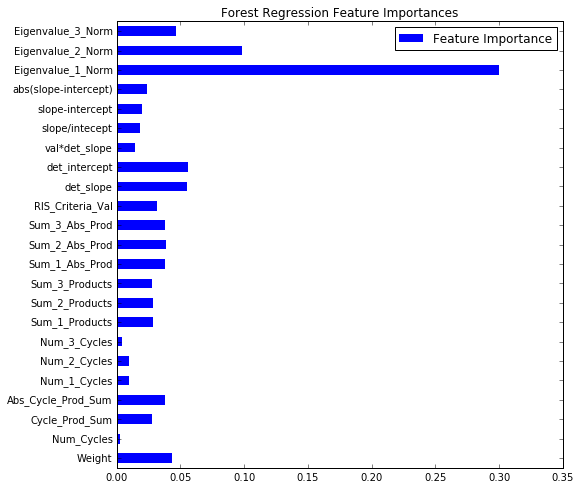

In [15]:
features = list(X.columns.values)
freg_avg_coefs = (np.mean(freg_coef,axis=0))
df = pd.DataFrame(freg_avg_coefs,index=features,columns=['Feature Importance'])
df.plot(kind='barh',figsize=(8,8),linewidth=0)
plt.xlim(0,.35)
plt.title("Forest Regression Feature Importances")
plt.show()

Above are the feature importance scores for the regression method. The addition of eigenvalue magnitudes and determinant properties clearly made a significant difference: The 3 eigenvalues and the determinant slope and intercept represented the 5 most important features in the model.

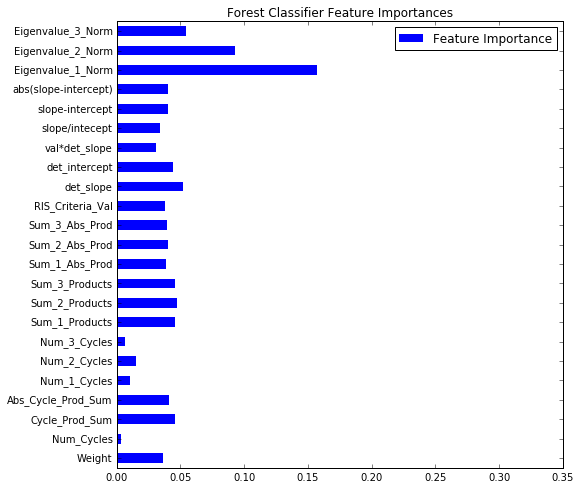

In [16]:
fclass_avg_coefs = (np.mean(fclass_coef,axis=0))
df = pd.DataFrame(fclass_avg_coefs,index=features,columns=['Feature Importance'])
df.plot(kind='barh',figsize=(8,8),linewidth=0)
plt.xlim(0,.35)
plt.title("Forest Classifier Feature Importances")
plt.show()

For the classifier, we see similar results, with the original cycle-product features slightly edging out determinant properites in importance. The 3 eigenvalues remained the most important features.

## Feature Reduction

Thus, the norms of the eigenvalues of the original network, and a more sophisticated version of cycle-products (determinant properties) are extremely valuable features in both models. 

We now explore how accurate our models can get, if we limit our data to just these features:

In [17]:
num_keep = 5
tosort_reg = np.array(list(reversed(np.argsort(freg_avg_coefs))))[:num_keep]
tosort_class = np.array(list(reversed(np.argsort(fclass_avg_coefs))))[:num_keep]

In [18]:
fclass_accs = np.zeros(len(networks)/num_samples)
freg_accs = np.zeros(len(networks)/num_samples)
fclass_stds = np.zeros(len(networks)/num_samples)
freg_stds = np.zeros(len(networks)/num_samples)
fclass_coef = np.zeros((len(networks)/num_samples,num_keep))
freg_coef = np.zeros((len(networks)/num_samples,num_keep))
for m in xrange(len(networks)/num_samples):
    X, y = feature_gen_all(networks[m*num_samples:(m+1)*num_samples], effects[m*num_samples:(m+1)*num_samples])
    learner_reg = Learner(X[tosort_reg],y)
    learner_class = Learner(X[tosort_class],y)
    learner_class.learn_forest_class(learner_class.X, (learner_class.y > 0), 1)
    learner_reg.learn_forest_regression(learner_reg.X, learner_reg.y, 1)
    fclass_accs[m] = learner_class.forest_class_acc
    freg_accs[m] = learner_reg.forest_reg_acc
    fclass_stds[m] = learner_class.forest_class_std
    freg_stds[m] = learner_reg.forest_reg_std
    fclass_coef[m] = learner_class.forest_class_coef
    freg_coef[m] = learner_reg.forest_reg_coef

In [19]:
print "Forest Regression R^2: ",np.mean(freg_accs)
print "Forest Classifier Accuracy: ",np.mean(fclass_accs)
print "Forest Regression Std_Dev:  ",np.mean(freg_stds)
print "Forest Classifier Std_Dev:  ",np.mean(fclass_stds)

Forest Regression R^2:  0.318020334961
Forest Classifier Accuracy:  0.807293783069
Forest Regression Std_Dev:   0.0
Forest Classifier Std_Dev:   0.0


Thus, retaining only the 5 most important features reduced our regression $R^2$ term significantly, but didn't impact the classifer hardly at all. 

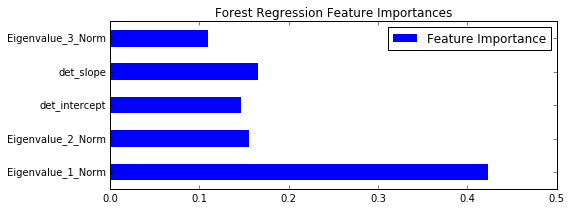

In [20]:
features_reg = list(np.array(X.columns.values)[tosort_reg])
features_class = list(np.array(X.columns.values)[tosort_class])
freg_avg_coefs = (np.mean(freg_coef,axis=0))
df = pd.DataFrame(freg_avg_coefs,index=features_reg,columns=['Feature Importance'])
df.plot(kind='barh',figsize=(8,3),linewidth=0)
plt.xlim(0,.5)
plt.title("Forest Regression Feature Importances")
plt.show()

Thus, the norm of the largest magnitude is still most important for regression.

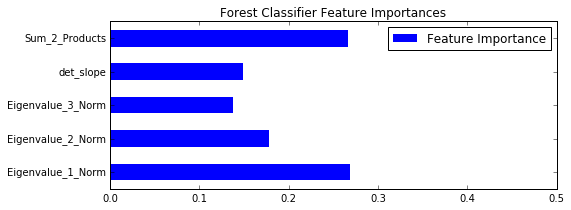

In [21]:
fclass_avg_coefs = (np.mean(fclass_coef,axis=0))
df = pd.DataFrame(fclass_avg_coefs,index=features_class,columns=['Feature Importance'])
df.plot(kind='barh',figsize=(8,3),linewidth=0)
plt.xlim(0,.5)
plt.title("Forest Classifier Feature Importances")
plt.show()

The classification results are particularly interesting. It appears to be sufficient to consider the norms of the eigenvalues, the sum of the 3-products, and the slope of determinent, as defined above. It is not immediately clear why these values are important, so further research is merited.

# V Conclusion

In sum, our primary question is answered: there is a discernable pattern regarding which edges in a network are resilient to time delays. We successfully achieved half of the potential accuracy above our baseline of 58%, using only 5 features in the classification case, and 23 features in the regression sense. We consider this to be a very valuable result, especially given the difficulty in selecting features that correllate with changes in spectral radius.

For an analytic result, much work remains. Further exploration of the spectral and determinant properties we used could result in a refinement that leads to a solution. The structures discovered in our data visualization are striking and well-defined, but it remains to be seen exactly what analytic critera correspond to those structures. This machine learning approach has given us strong direction to pursue, in search of a genuine theorem for time-delay dynamical stability.